<a href="https://colab.research.google.com/github/metsumesquita/master_degree_UPE/blob/main/sarima_forecastingipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
! pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.6 MB/s eta 0:00:00


In [44]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import auto_arima


import statsmodels.api as sm


In [ ]:
#/content/drive/MyDrive/air_inputado.csv

In [31]:
df = pd.read_csv('air_inputado.csv')

In [32]:
import pandas as pd

# Assuming your DataFrame has 365 rows

# Create a date range for the entire year 2017
new_index = pd.date_range(start='2017-01-01', end='2017-12-31')

# Set the new index for your DataFrame
df.index = new_index

print(df.head())  # View the DataFrame with the new index

            Time_PM10  Time_NO2  Spline_order_3_O3  Spline_order_3_CO  \
2017-01-01       63.0       2.0               21.0               25.0   
2017-01-02       16.0       1.0               19.0               16.0   
2017-01-03       18.0       2.0               20.0               17.0   
2017-01-04       24.0       2.0               20.0               22.0   
2017-01-05       29.0       2.0               14.0               25.0   

            Time_SO2  
2017-01-01      34.0  
2017-01-02      32.0  
2017-01-03      32.0  
2017-01-04      32.0  
2017-01-05      32.0  


#estacionariodariada

In [33]:

# Função para testar a estacionaridade de cada coluna
def testar_estacionaridade(df):
    resultados = {}
    for coluna in df.columns:
        resultado = adfuller(df[coluna])
        resultados[coluna] = {
            'ADF Statistic': resultado[0],
            'p-value': resultado[1],
            'Lags Used': resultado[2],
            'Number of Observations Used': resultado[3],
            'Critical Value (1%)': resultado[4]['1%'],
            'Critical Value (5%)': resultado[4]['5%'],
            'Critical Value (10%)': resultado[4]['10%']
        }
    return resultados

# Testando a estacionaridade
resultados = testar_estacionaridade(df)

# Exibindo os resultados
for coluna, res in resultados.items():
    print(f"Resultados para {coluna}:")
    for chave, valor in res.items():
        print(f"  {chave}: {valor}")
    print("\n")


Resultados para Time_PM10:
  ADF Statistic: -3.728850634269577
  p-value: 0.003725167284055798
  Lags Used: 6
  Number of Observations Used: 358
  Critical Value (1%): -3.448748905151901
  Critical Value (5%): -2.8696473721448728
  Critical Value (10%): -2.5710891239349585


Resultados para Time_NO2:
  ADF Statistic: -2.9227724664250245
  p-value: 0.0427632337422974
  Lags Used: 13
  Number of Observations Used: 351
  Critical Value (1%): -3.44911857009962
  Critical Value (5%): -2.8698097654570507
  Critical Value (10%): -2.5711757061225153


Resultados para Spline_order_3_O3:
  ADF Statistic: -4.292825794889393
  p-value: 0.0004570926056593359
  Lags Used: 4
  Number of Observations Used: 360
  Critical Value (1%): -3.448645946352023
  Critical Value (5%): -2.869602139060357
  Critical Value (10%): -2.5710650077160495


Resultados para Spline_order_3_CO:
  ADF Statistic: -4.684625425936142
  p-value: 8.993083328117963e-05
  Lags Used: 5
  Number of Observations Used: 359
  Critical V

#VISUALIZAÇÃO ACF 0 PACF

In [34]:
def acf_pacf(series, lags, figsize=(15, 6), title_prefix=""):
    """
    Gera gráficos de ACF (Autocorrelação) e PACF (Autocorrelação Parcial).

    Parâmetros:
    - series: Série temporal (array ou pandas Series).
    - lags: Número de lags (defasagens) para calcular as correlações.
    - figsize: Tamanho da figura (largura, altura).
    - title_prefix: Prefixo para os títulos dos gráficos (como o nome da coluna).
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # ACF
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title(f"{title_prefix} - ACF")

    # PACF
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title(f"{title_prefix} - PACF")

    # Ajustar layout
    plt.tight_layout()
    plt.show()

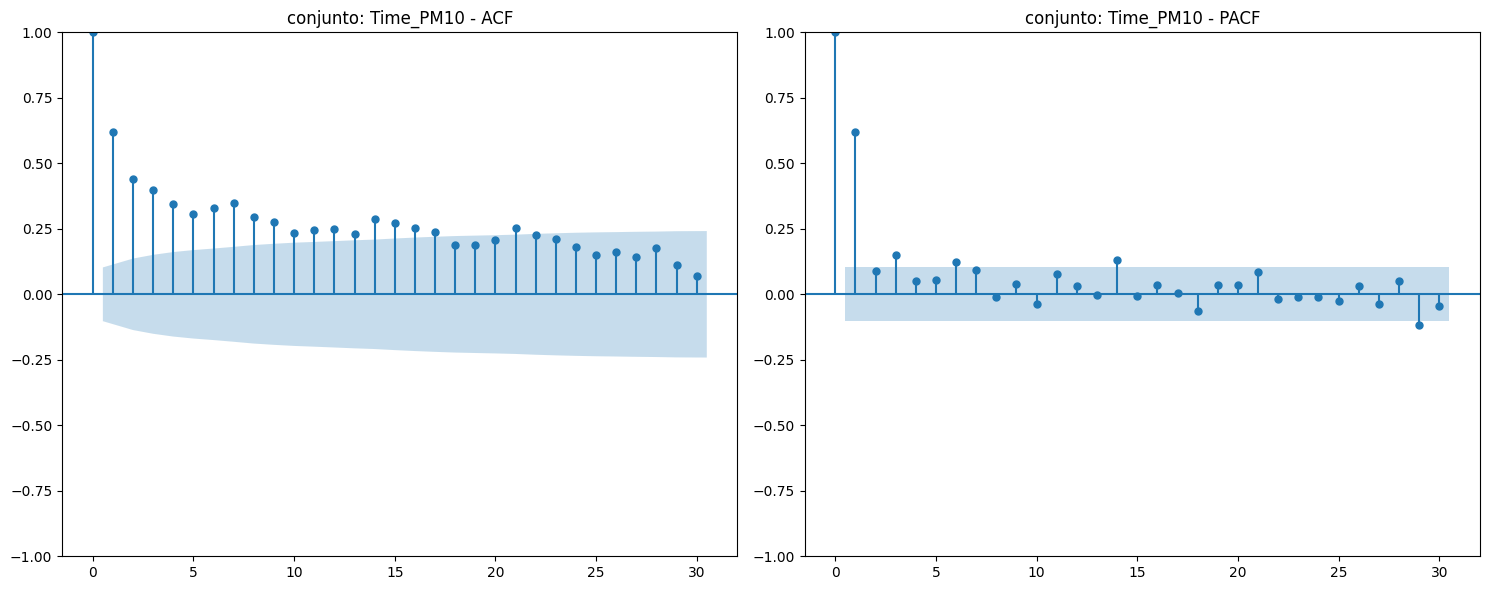

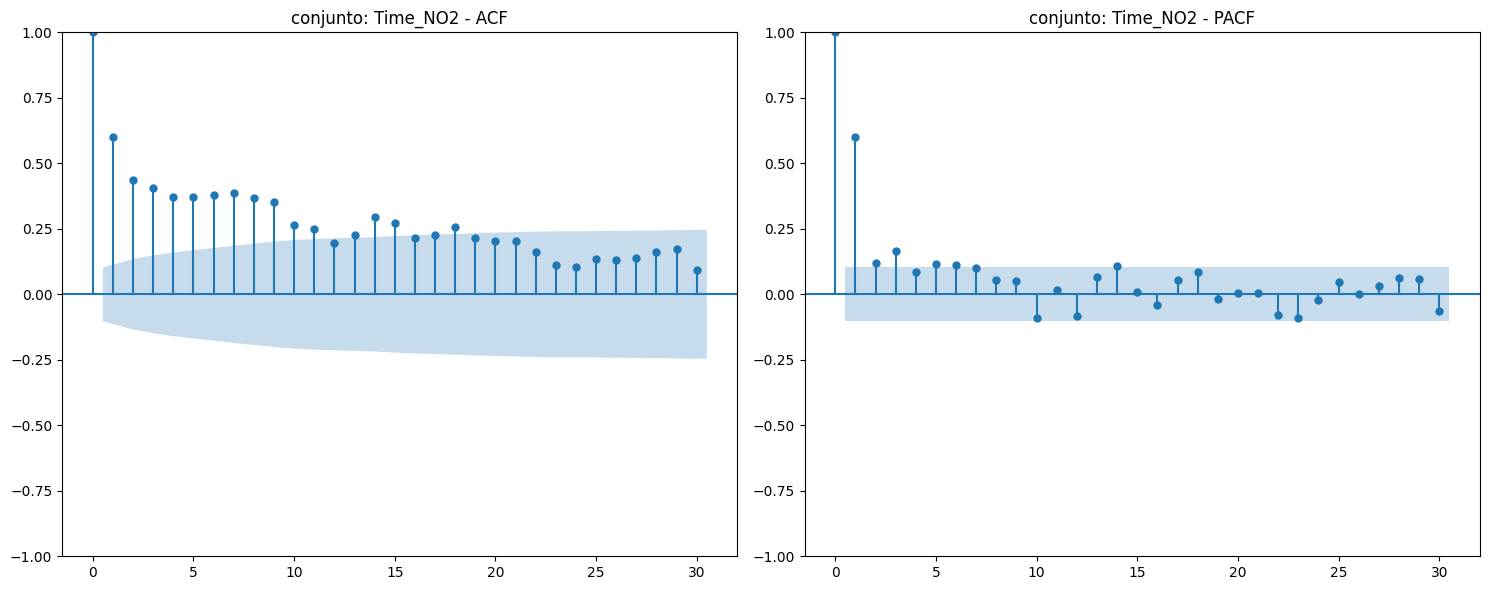

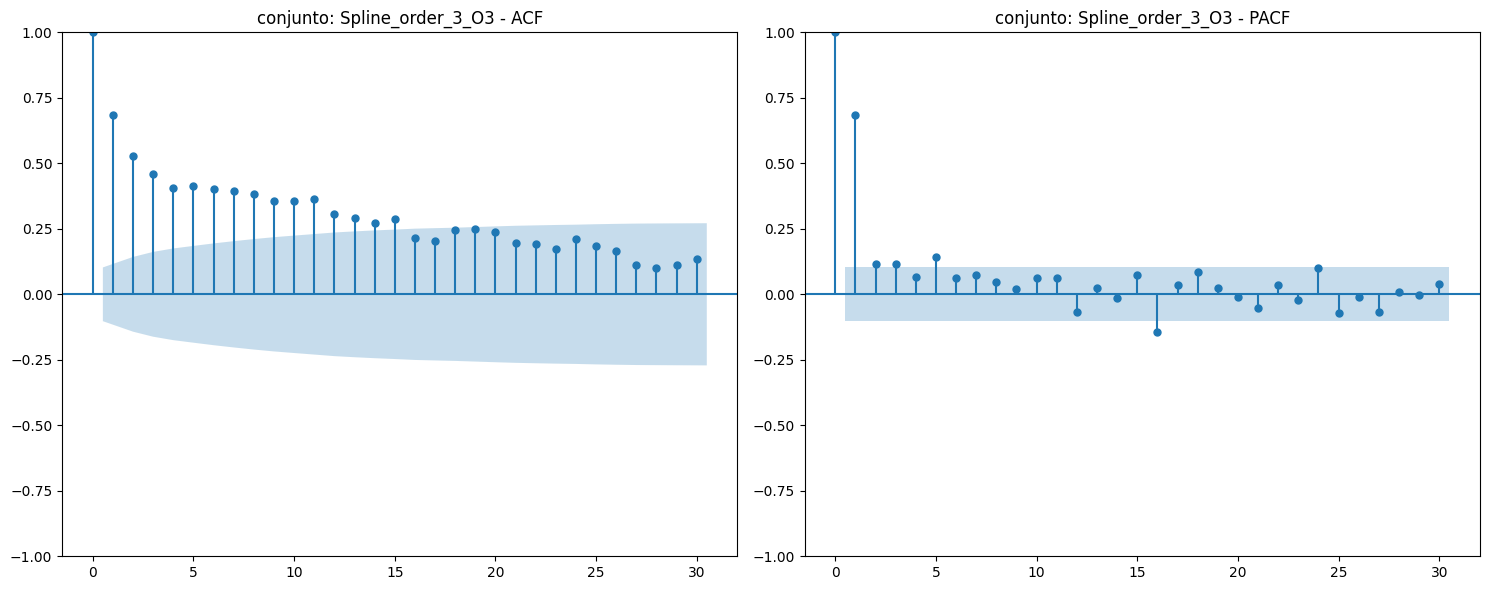

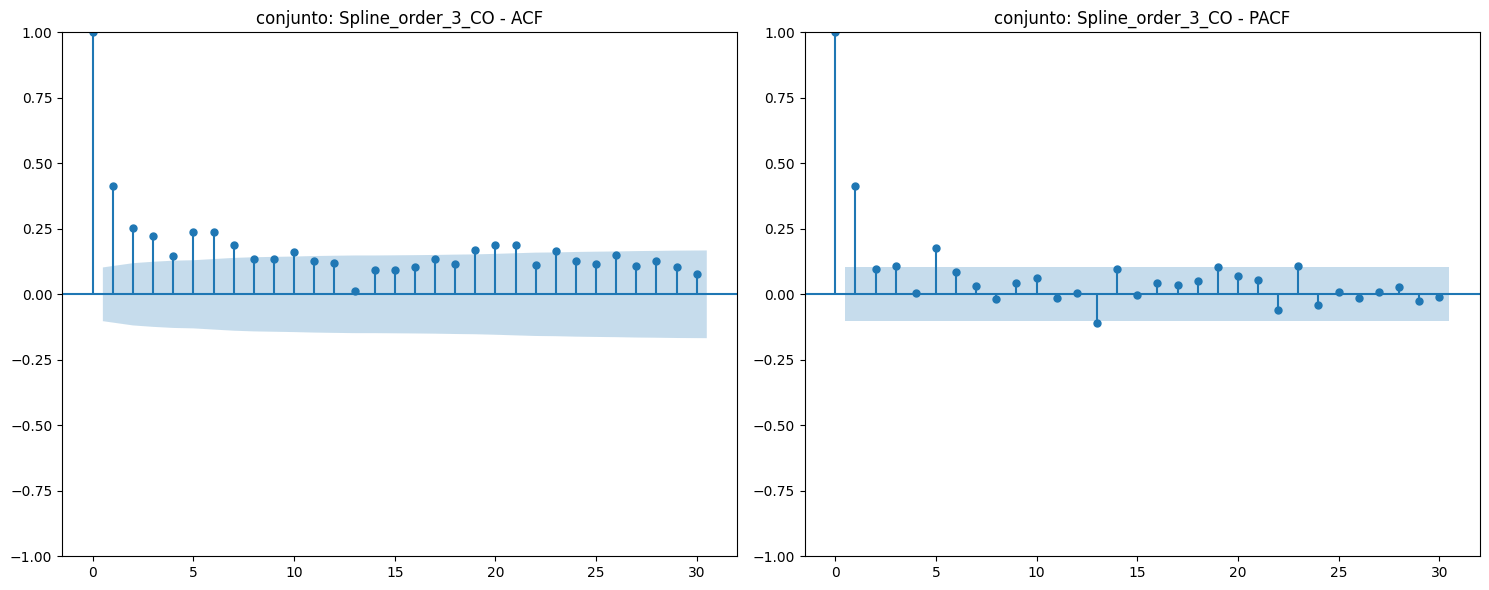

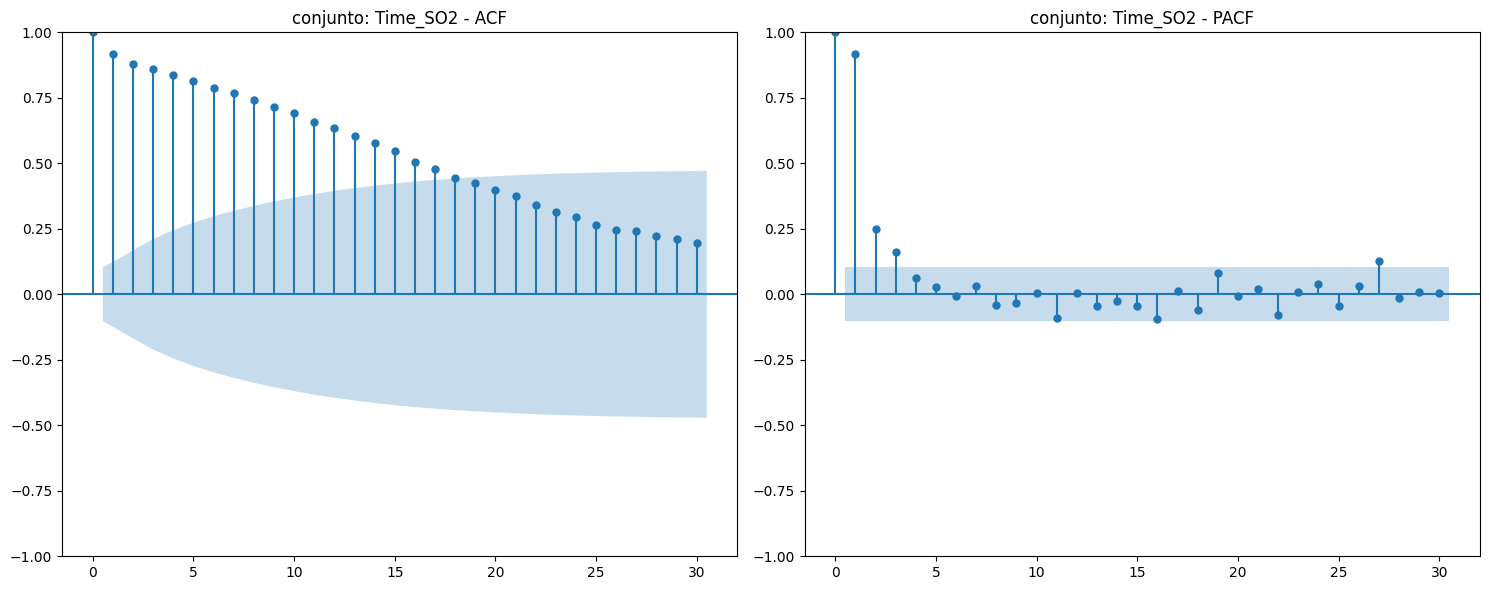

In [22]:

for column in df.columns:
    acf_pacf(df[column], lags=30, title_prefix=f"conjunto: {column}")

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2017-01-01 to 2017-12-31
Freq: D
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time_PM10          365 non-null    float64
 1   Time_NO2           365 non-null    float64
 2   Spline_order_3_O3  365 non-null    float64
 3   Spline_order_3_CO  365 non-null    float64
 4   Time_SO2           365 non-null    float64
dtypes: float64(5)
memory usage: 17.1 KB


In [36]:

train_data = df.loc['2017-01-01':'2017-10-31']  # Treinamento: Janeiro a Outubro de 2017

test_data = df.loc['2017-11-01':'2017-12-31']   # Teste: Novembro e Dezembro de 2017


In [37]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2017-01-01 to 2017-10-31
Freq: D
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time_PM10          304 non-null    float64
 1   Time_NO2           304 non-null    float64
 2   Spline_order_3_O3  304 non-null    float64
 3   Spline_order_3_CO  304 non-null    float64
 4   Time_SO2           304 non-null    float64
dtypes: float64(5)
memory usage: 14.2 KB


In [26]:
from sklearn.preprocessing import MinMaxScaler


In [38]:
scaler_pm10 = MinMaxScaler()

scaler_pm10.fit(train_data['Time_PM10'].values.reshape(-1, 1))

scaler_no2 = MinMaxScaler()

scaler_no2.fit(train_data['Time_NO2'].values.reshape(-1, 1))

scaler_so2 = MinMaxScaler()

scaler_so2.fit(train_data['Time_SO2'].values.reshape(-1, 1))

scaler_o3 = MinMaxScaler()
scaler_o3.fit(train_data['Spline_order_3_O3'].values.reshape(-1, 1))

scaler_co = MinMaxScaler()
scaler_co.fit(train_data['Spline_order_3_CO'].values.reshape(-1, 1))

MinMaxScaler()

In [39]:

train_data_normalized = train_data.copy()
train_data_normalized['Time_PM10'] = scaler_pm10.transform(train_data['Time_PM10'].values.reshape(-1, 1))
train_data_normalized['Time_NO2'] = scaler_no2.transform(train_data['Time_NO2'].values.reshape(-1, 1))
train_data_normalized['Time_SO2'] = scaler_so2.transform(train_data['Time_SO2'].values.reshape(-1, 1))
train_data_normalized['Spline_order_3_O3'] = scaler_o3.transform(train_data['Spline_order_3_O3'].values.reshape(-1, 1))
train_data_normalized['Spline_order_3_CO'] = scaler_co.transform(train_data['Spline_order_3_CO'].values.reshape(-1, 1))

# Normalizar os dados de teste
test_data_normalized = test_data.copy()
test_data_normalized['Time_PM10'] = scaler_pm10.transform(test_data['Time_PM10'].values.reshape(-1, 1))
test_data_normalized['Time_NO2'] = scaler_no2.transform(test_data['Time_NO2'].values.reshape(-1, 1))
test_data_normalized['Time_SO2'] = scaler_so2.transform(test_data['Time_SO2'].values.reshape(-1, 1))
test_data_normalized['Spline_order_3_O3'] = scaler_o3.transform(test_data['Spline_order_3_O3'].values.reshape(-1, 1))
test_data_normalized['Spline_order_3_CO'] = scaler_co.transform(test_data['Spline_order_3_CO'].values.reshape(-1, 1))

#coorelograma

In [ ]:

import pandas as pd
import numpy as np
import statsmodels.api as sm

In [40]:
def acf_pacf(series, lags, figsize=(15, 6), title_prefix=""):
    """
    Gera gráficos de ACF (Autocorrelação) e PACF (Autocorrelação Parcial).

    Parâmetros:
    - series: Série temporal (array ou pandas Series).
    - lags: Número de lags (defasagens) para calcular as correlações.
    - figsize: Tamanho da figura (largura, altura).
    - title_prefix: Prefixo para os títulos dos gráficos (como o nome da coluna).
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # ACF
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title(f"{title_prefix} - ACF")

    # PACF
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title(f"{title_prefix} - PACF")

    # Ajustar layout
    plt.tight_layout()
    plt.show()


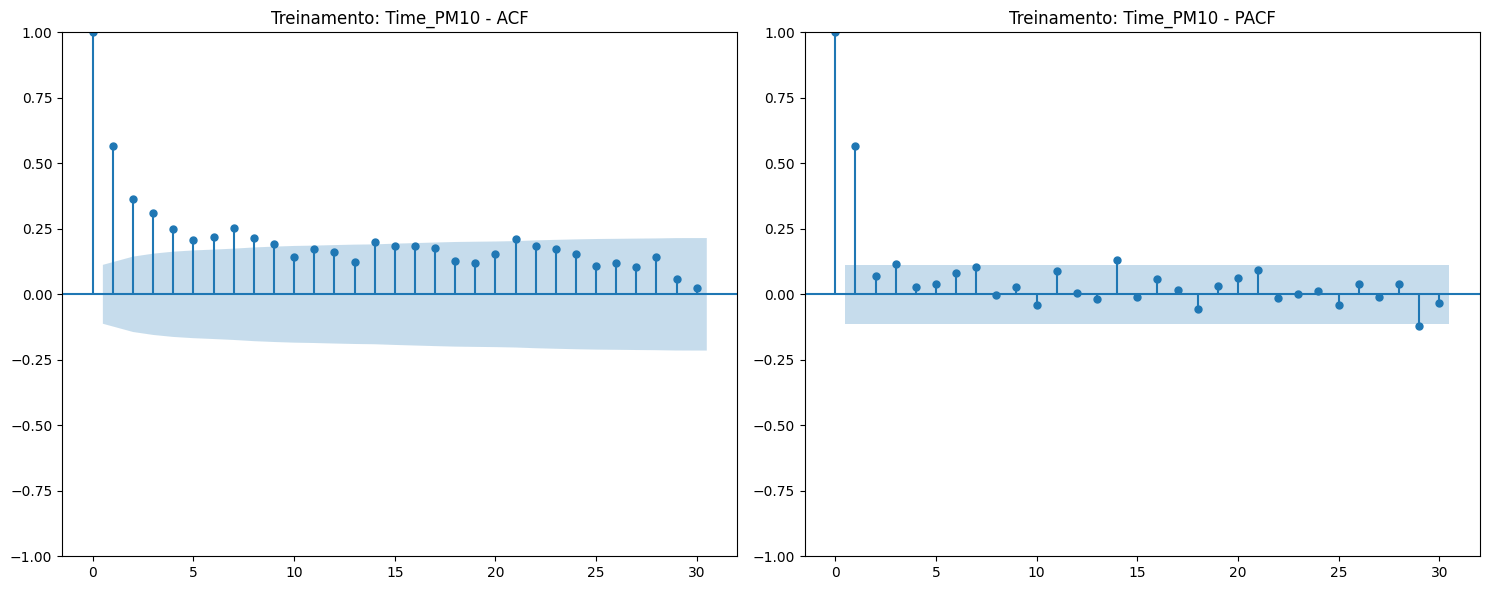

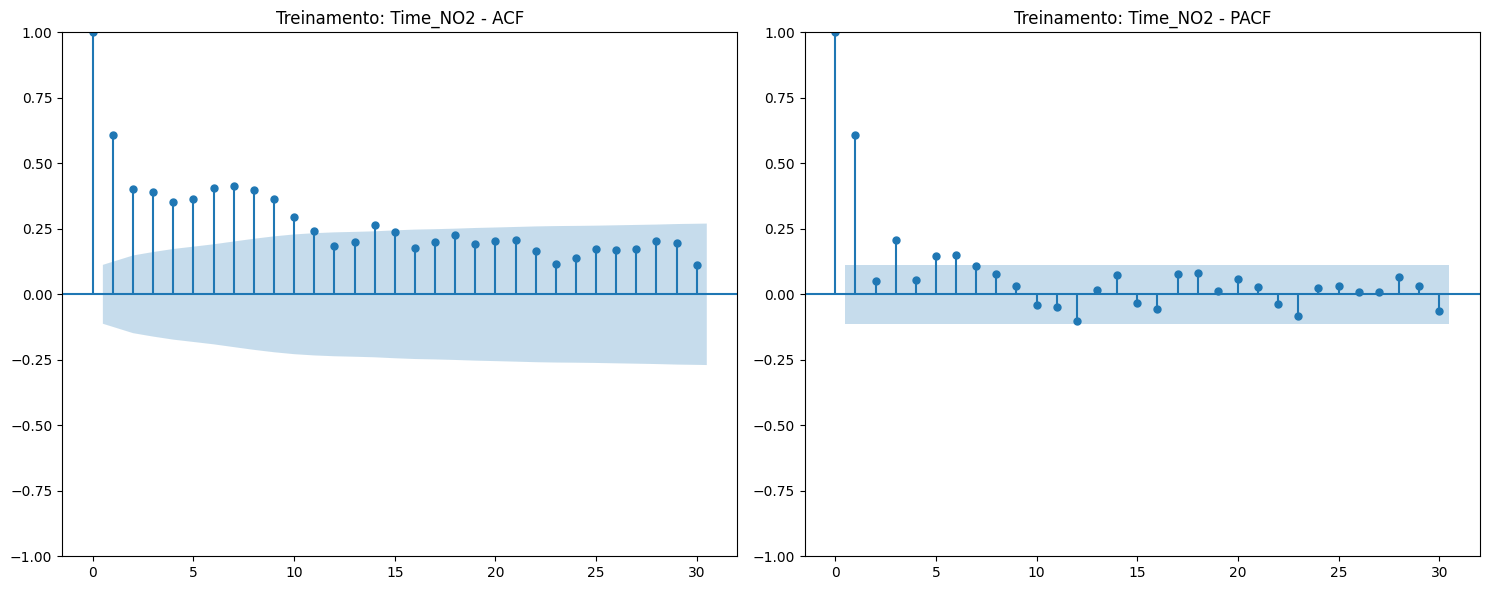

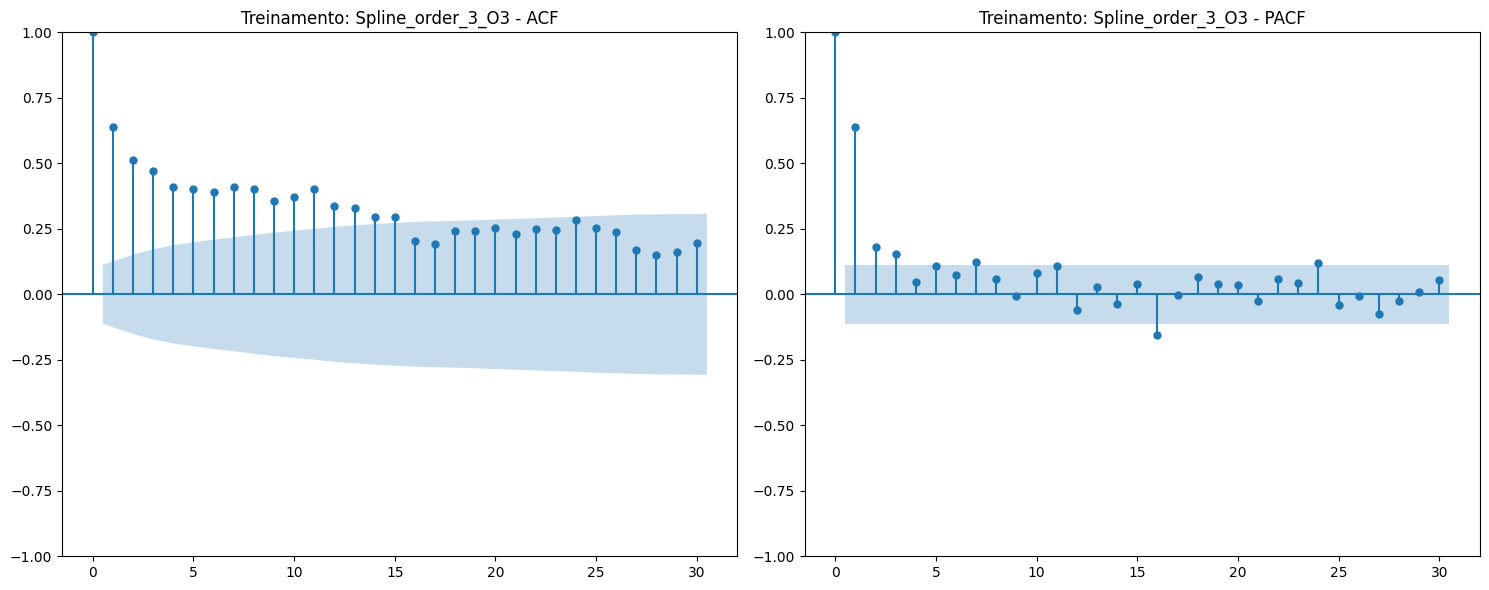

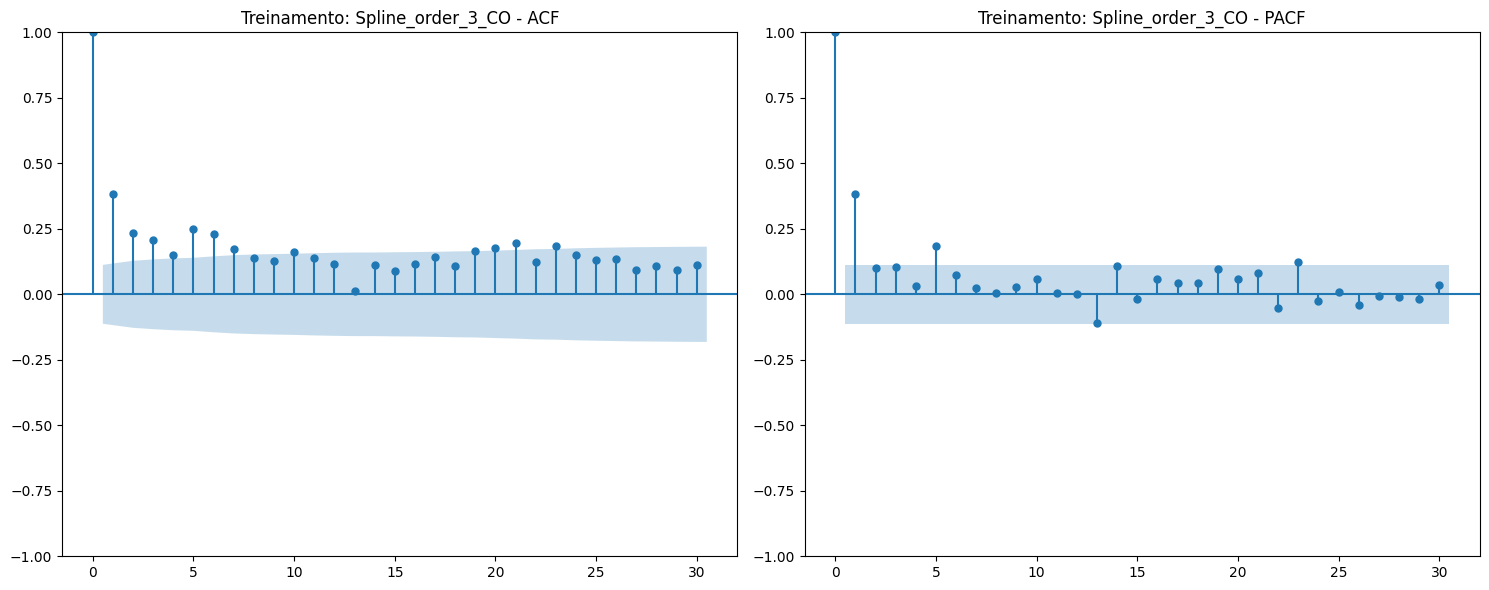

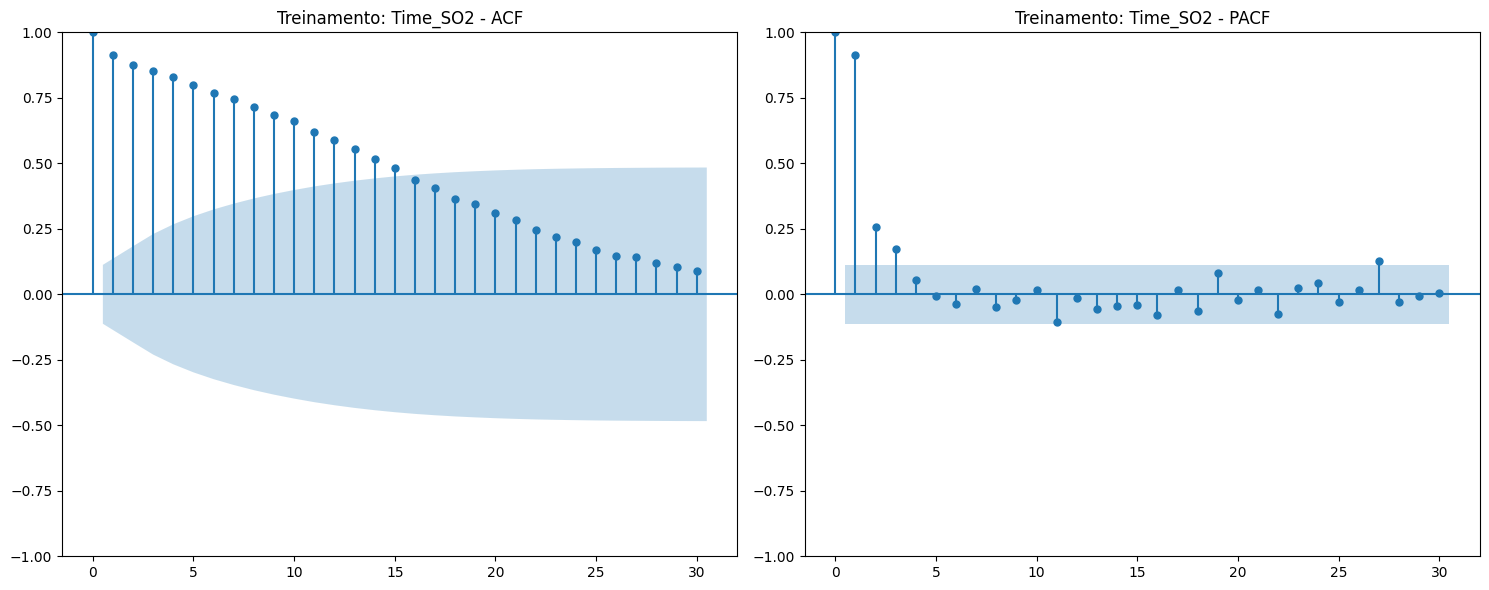

In [41]:
# Para o conjunto de treinamento
for column in train_data_normalized.columns:
    acf_pacf(train_data_normalized[column], lags=30, title_prefix=f"Treinamento: {column}")

In [42]:

train_pm10=train_data_normalized['Time_PM10']
train_no2=train_data_normalized['Time_NO2']
train_o3=train_data_normalized['Spline_order_3_O3']
train_co=train_data_normalized['Spline_order_3_CO']
train_so2=train_data_normalized['Time_SO2']

test_pm10 =test_data_normalized['Time_PM10']
test_no2 =test_data_normalized['Time_NO2']
test_o3 =test_data_normalized['Spline_order_3_O3']
test_co =test_data_normalized['Spline_order_3_CO']
test_so2 =test_data_normalized['Time_SO2']


#esse

<Axes: title={'center': 'Série SO2 Diferenciada'}>

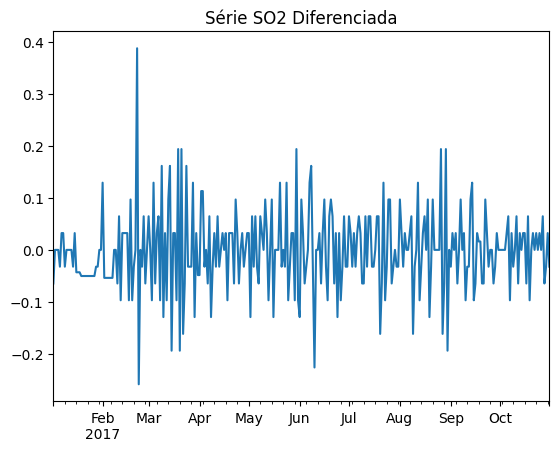

In [52]:
import pandas as pd

# Diferenciação simples
train_so2_diff = train_so2.diff().dropna()

# Visualizar a série diferenciada
train_so2_diff.plot(title='Série SO2 Diferenciada')


In [53]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_so2_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("A série diferenciada é estacionária.")
else:
    print("A série ainda não é estacionária.")


ADF Statistic: -14.17839382570633
p-value: 1.9478688205428952e-26
A série diferenciada é estacionária.


sazonalidade

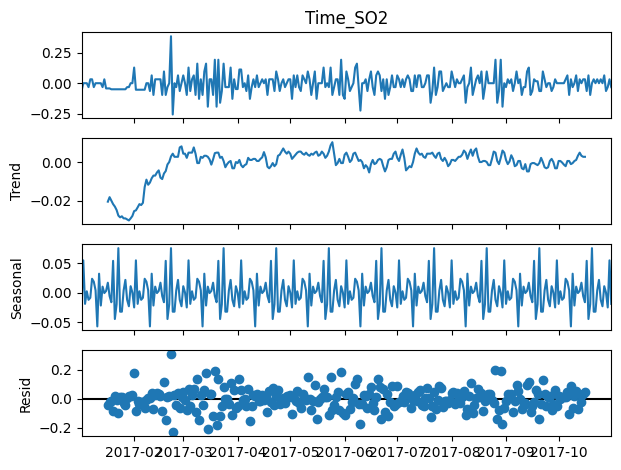

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decomposição sazonal (ajuste o parâmetro period conforme necessário, ex.: 12 para dados mensais)
decomposicao = seasonal_decompose(train_so2_diff, model='additive', period=30)
decomposicao.plot()
plt.show()


Analisando sazonalidade para a coluna: Time_PM10


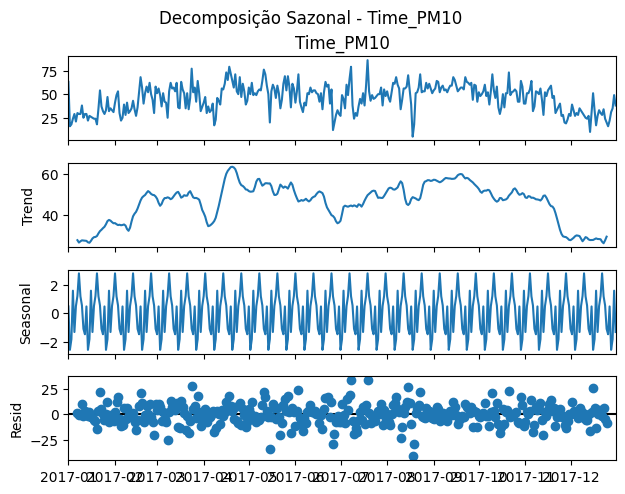

Analisando sazonalidade para a coluna: Time_NO2


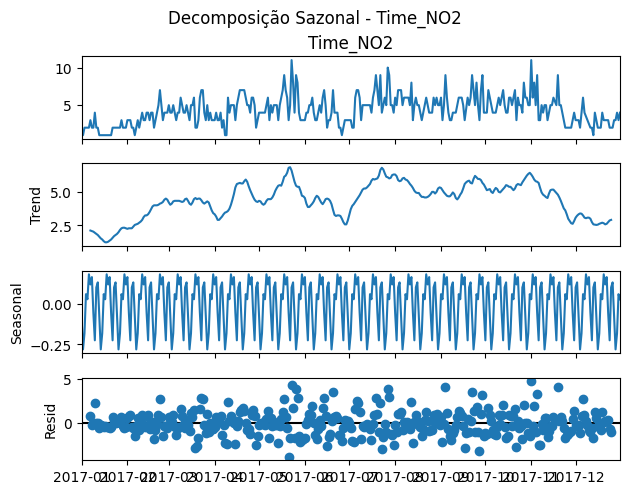

Analisando sazonalidade para a coluna: Spline_order_3_O3


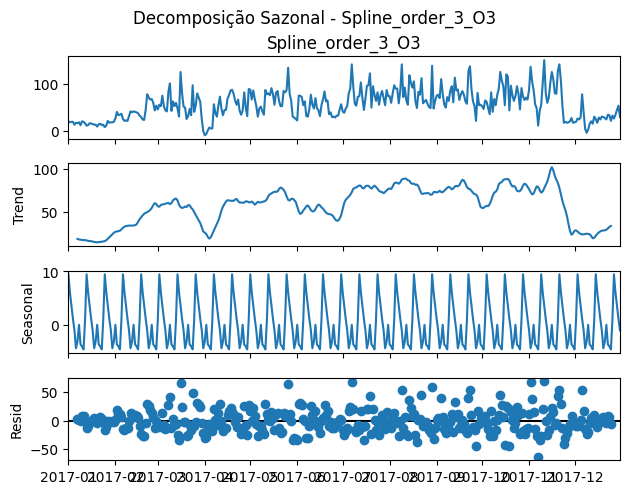

Analisando sazonalidade para a coluna: Spline_order_3_CO


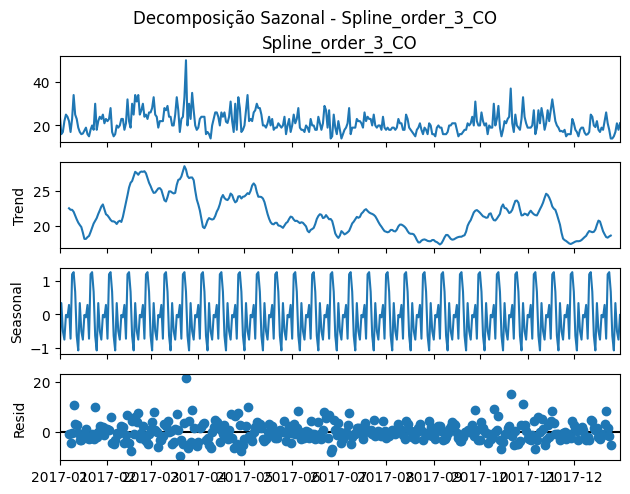

Analisando sazonalidade para a coluna: Time_SO2


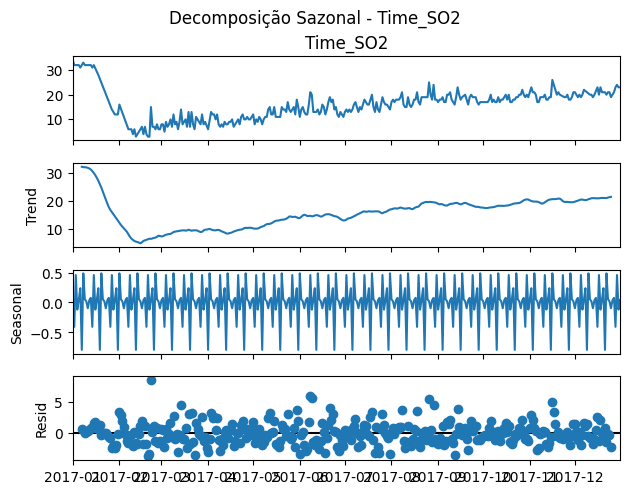

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Iterar por cada coluna do DataFrame
for coluna in df.columns:
    print(f"Analisando sazonalidade para a coluna: {coluna}")
    serie_temporal = df[coluna]

    # Realizar decomposição sazonal (ajuste o período, ex.: 12 para dados mensais)
    decomposicao = seasonal_decompose(serie_temporal, model='additive', period=12)

    # Plotar os componentes
    decomposicao.plot()
    plt.suptitle(f"Decomposição Sazonal - {coluna}", y=1.02)
    plt.show()


#modelo sarima

In [55]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from pmdarima import auto_arima

# Definir nomes das variáveis de treino e teste
dados = {
    'pm10': {'treino': train_pm10, 'teste': test_pm10},
    'so2': {'treino': train_so2_diff, 'teste': test_so2},
    'o3': {'treino': train_o3, 'teste': test_o3},
    'co': {'treino': train_co, 'teste': test_co},
    'no2': {'treino': train_no2, 'teste': test_no2}
    # Adicione outras séries aqui
}

# Dicionário para armazenar resultados
resultados = {}

# Loop pelas séries temporais
for nome, valores in dados.items():
    print(f"\nAnalisando série: {nome.upper()}")

    # Obter treino e teste
    treino = valores['treino']
    teste = valores['teste']

    # Ajustar modelo SARIMA automaticamente
    modelo_auto = auto_arima(
        treino,
        seasonal=True,
        m=12,  # Ajuste conforme o período sazonal
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    # Treinar modelo no conjunto de treinamento
    modelo_final = modelo_auto.fit(treino)

    # Fazer previsões no conjunto de teste
    previsoes = modelo_final.predict(n_periods=len(teste))

    # Calcular métricas
    mae = mean_absolute_error(teste, previsoes)
    rmse = np.sqrt(mean_squared_error(teste, previsoes))
    mape = np.mean(np.abs((teste - previsoes) / teste)) * 100

    # Armazenar resultados no dicionário
    resultados[nome] = {
        'modelo': modelo_final,
        'previsoes': previsoes,
        'valores_reais': teste.values,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    # Exibir métricas
    print(f"Métricas para {nome.upper()}:")
    print(f"  MAE: {mae}")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}%")

# Criar DataFrame com métricas resumidas
metricas_df = pd.DataFrame({
    serie: {
        'MAE': resultados[serie]['mae'],
        'RMSE': resultados[serie]['rmse'],
        'MAPE': resultados[serie]['mape']
    } for serie in dados.keys()
}).T

print("\nResumo das Métricas:")
print(metricas_df)

# Opcional: salvar métricas e previsões
metricas_df.to_csv('metricas_sarima.csv')



Analisando série: PM10
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-326.663, Time=6.93 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-253.692, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-271.223, Time=0.46 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-298.060, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-255.681, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-328.657, Time=1.92 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-330.716, Time=0.81 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-328.656, Time=1.87 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-331.839, Time=0.77 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-329.856, Time=1.86 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-329.855, Time=4.39 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-327.860, Time=1.91 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-330.106, Time=0.53 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-333.625, Time=0.46 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-331.648, Time=1.36 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-331.646, Time=1.66 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-329.658, Time=2.46 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-299.864, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-273.197, Time=0.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-331.786, Time=0.68 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-292.192, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-334.546, Time=0.68 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-332.560, Time=2.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12]             : AIC=-332.559, Time=1.78 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12]             : AIC=-330.617, Time=1.21 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-301.829, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-275.194, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12]             : AIC=-332.764, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=-332.829, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[12]             : AIC=-331.420, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=-294.192, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12]             : AIC=-331.674, Time=0.37 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 36.137 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Métricas para PM10:
  MAE: 0.2038236413404001
  RMSE: 0.23921298239150773
  MAPE: 86.66293416047112%

Analisando série: SO2
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-742.646, Time=2.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-691.971, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-724.103, Time=0.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-746.374, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-693.839, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-747.667, Time=0.20 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-746.474, Time=0.49 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-745.750, Time=1.40 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-747.013, Time=0.26 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-747.437, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-725.998, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-746.273, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=-749.151, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[12]             : AIC=-747.999, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12]             : AIC=-747.894, Time=0.21 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12]             : AIC=-747.249, Time=0.78 sec
 ARIMA(1,0,1)(0,0,0)[12]             : AIC=-748.447, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[12]             : AIC=-748.863, Time=0.74 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=-727.760, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[12]             : AIC=-747.714, Time=0.84 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12]          
Total fit time: 9.647 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Métricas para SO2:
  MAE: 0.5616484633992811
  RMSE: 0.5644256945363921
  MAPE: 99.96149765829145%

Analisando série: O3
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-309.803, Time=3.54 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-229.536, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-261.150, Time=0.52 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-294.337, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-231.525, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-311.755, Time=1.85 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-313.876, Time=0.79 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-311.849, Time=2.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.72 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-315.798, Time=0.78 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-314.083, Time=3.80 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-314.049, Time=2.26 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=-312.202, Time=2.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-316.979, Time=0.39 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-315.554, Time=1.21 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-315.472, Time=1.22 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-315.409, Time=1.82 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-296.318, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-262.711, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-312.881, Time=0.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-280.207, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-317.282, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-315.859, Time=0.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12]             : AIC=-315.772, Time=0.40 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12]             : AIC=-315.843, Time=2.21 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-298.129, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-264.687, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12]             : AIC=-315.562, Time=0.46 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12]             : AIC=-315.642, Time=1.50 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=-314.096, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[12]             : AIC=-282.166, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12]             : AIC=-314.403, Time=0.42 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 31.135 seconds
Métricas para O3:
  MAE: 0.2794563532863235
  RMSE: 0.30599256663254604
  MAPE: 141.09633967920942%

Analisando série: CO
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-411.490, Time=2.92 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-300.814, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-343.040, Time=0.39 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-406.583, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-302.812, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-413.490, Time=1.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-415.635, Time=0.97 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-413.492, Time=2.22 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-416.918, Time=1.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-414.666, Time=4.37 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-414.919, Time=1.66 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-412.917, Time=1.98 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-418.353, Time=0.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=-416.358, Time=0.90 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=-416.358, Time=1.84 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=-414.357, Time=2.44 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-407.840, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=-416.669, Time=2.48 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-418.916, Time=0.94 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-416.917, Time=2.01 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-416.917, Time=1.37 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-414.917, Time=1.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-344.963, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-416.918, Time=0.61 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-369.110, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-420.898, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12]             : AIC=-418.899, Time=0.32 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12]             : AIC=-418.899, Time=0.64 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12]             : AIC=-416.900, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-409.818, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-346.963, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12]             : AIC=-418.900, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12]             : AIC=-418.900, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=-420.329, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=-371.107, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12]             : AIC=-417.463, Time=0.28 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12]          
Total fit time: 35.019 seconds
Métricas para CO:
  MAE: 0.11233597512519121
  RMSE: 0.12760878429256042
  MAPE: inf%

Analisando série: NO2


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-318.571, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-229.658, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-248.655, Time=0.45 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-298.997, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-231.647, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-320.939, Time=4.16 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-316.483, Time=0.75 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-319.203, Time=4.49 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-320.371, Time=1.99 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-317.176, Time=7.65 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-322.803, Time=1.42 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-318.133, Time=0.52 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-321.070, Time=1.93 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-321.056, Time=4.17 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-322.228, Time=3.93 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=-319.036, Time=5.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=-324.145, Time=1.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-320.070, Time=0.40 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=-322.439, Time=1.67 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=-322.407, Time=5.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=-323.660, Time=1.86 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,2)[12] intercept   : AIC=-320.372, Time=4.31 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,1)[12] intercept   : AIC=-322.690, Time=1.41 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-318.531, Time=1.37 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,1)[12] intercept   : AIC=-320.709, Time=1.36 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[12]             : AIC=-325.056, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=-321.203, Time=0.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12]             : AIC=-323.261, Time=0.78 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,2)[12]             : AIC=-323.249, Time=2.82 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[12]             : AIC=-324.636, Time=1.42 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,2)[12]             : AIC=-321.262, Time=1.78 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12]             : AIC=-300.354, Time=0.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12]             : AIC=-323.811, Time=0.66 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,1)[12]             : AIC=-323.725, Time=0.62 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12]             : AIC=-319.256, Time=0.41 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,1)[12]             : AIC=-321.898, Time=1.35 sec

Best model:  ARIMA(0,1,2)(0,0,1)[12]          
Total fit time: 69.521 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Métricas para NO2:
  MAE: 0.2176755640122576
  RMSE: 0.24983631858458516
  MAPE: inf%

Resumo das Métricas:
           MAE      RMSE        MAPE
pm10  0.203824  0.239213   86.662934
so2   0.561648  0.564426   99.961498
o3    0.279456  0.305993  141.096340
co    0.112336  0.127609         inf
no2   0.217676  0.249836         inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [56]:
def calcular_metricas(valores_reais, previsoes):
    """
    Calcula MAE, RMSE e MAPE para previsões.

    Args:
    - valores_reais: Valores reais (array ou Series).
    - previsoes: Previsões do modelo (array ou Series).

    Returns:
    - Um dicionário com as métricas.
    """
    mae = mean_absolute_error(valores_reais, previsoes)
    rmse = np.sqrt(mean_squared_error(valores_reais, previsoes))
    mape = np.mean(np.abs((valores_reais - previsoes) / np.maximum(valores_reais, 1e-5))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}


In [49]:
metricas = calcular_metricas(teste, previsoes)
resultados[nome] = {
    'modelo': modelo_final,
    'previsoes': previsoes,
    'valores_reais': teste.values,
    **metricas
}


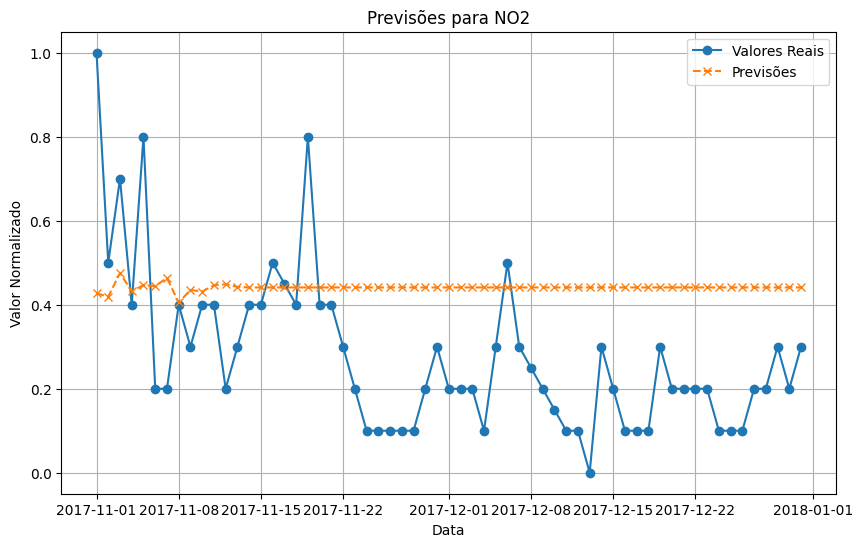

In [58]:
import matplotlib.pyplot as plt

# Visualização de previsões vs valores reais
plt.figure(figsize=(10, 6))
plt.plot(teste.index, teste, label='Valores Reais', marker='o')
plt.plot(teste.index, previsoes, label='Previsões', linestyle='--', marker='x')
plt.title(f"Previsões para {nome.upper()}")
plt.xlabel("Data")
plt.ylabel("Valor Normalizado")
plt.legend()
plt.grid()
plt.show()


#2700

#casa

In [ ]:
METRICA :CO
MAE: 0.11233597512519121
  RMSE: 0.12760878429256042
  MAPE: inf%
  Best model:  ARIMA(1,1,1)(0,0,0)[12]
ARIMA(1,1,1)(0,0,0)[12]


Métricas para NO2:
  MAE: 0.2176755640122576
  RMSE: 0.24983631858458516
  MAPE: inf%
Best model:  ARIMA(0,1,2)(0,0,1)[12]


Métricas para O3:
  MAE: 0.2794563532863235
  RMSE: 0.30599256663254604
  MAPE: 141.09633967920942%
  ARIMA(1,1,1)(0,0,0)[12]



  Métricas para SO2:
  MAE: 0.04870964714912469
  RMSE: 0.06452549307143915
  MAPE: 8.245352368127957%

Best model:  ARIMA(0,1,1)(0,0,0)[12]

Métricas para PM10:
  MAE: 0.2038236413404001
  RMSE: 0.23921298239150773
  MAPE: 86.66293416047112%
   ARIMA(1,1,1)(0,0,0)[12]

In [ ]:
#https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd